# Imports

In [1]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path
import gc

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio.PDB import *
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm

torch.set_grad_enabled(False)

In [2]:
import torch.nn as nn

# Define Functions

## Parsing alignments

In [3]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

## Converting structures to contacts

In [4]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

## Subsampling MSA

In [5]:
# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter 
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

## Compute contact precisions

In [6]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

## Drop missing residues from contacts

In [7]:
parser = PDBParser(PERMISSIVE = True, QUIET = True) 
pdbl = PDBList() 

def get_pdb_residues(pdb_id):
    pdb = pdb_id.upper()[:4]
    chain_id = pdb_id.upper()[-1]
    
    ## Download the pdb file, get the data from it and remove it
    pdbl.retrieve_pdb_file(pdb_id.upper()[:4], pdir = '.', file_format = 'pdb')
    data = parser.get_structure(pdb,"pdb" + pdb.lower() + ".ent")
    os.remove("pdb" + pdb.lower() + ".ent")

    all_residues = {}

    ## Identify the residues missing from the PDB file
    missing = [res for res in data.header["missing_residues"] if res["chain"] == chain_id]
    for res in missing:
        key = res["ssseq"]
        all_residues[key] = False

    ## Identify the residues present in the PDB file
    model = list(data.get_models())[0]
    chains = list(model.get_chains()) 
    present = list([chain for chain in chains if chain.id == chain_id][0].get_residues())
    present = [res for res in present if str(res)[17] == ' ']
    for res in present:
        if not str(res)[28].isnumeric():
            key = int(str(res)[26:28])
        elif not str(res)[29].isnumeric():
            key = int(str(res)[26:29])
        else:
            key = int(str(res)[26:30])
        all_residues[key] = True

    ## Iterate through all residues and keep the ones present in the PDB file, but with the correct index
    pdb_indices_to_keep = []
    index = 0
    for i in range(10000):
        if i in all_residues:
            if all_residues[i]:
                pdb_indices_to_keep.append(index)
            index += 1
    return pdb_indices_to_keep

## Clear the models to save up memory

In [8]:
def clear_model(model):
    if type(model) == "esm.model.msa_transformer.MSATransformer":
        msa_transformer = None
        msa_transformer_embeddings = None
        msa_transformer_batch_tokens = None
        msa_transformer_alphabet = None
        msa_transformer_predictions = None
    if type(model) == "esm.model.esm2.ESM2":
        esm2_transformer = None
        esm2_transformer_embeddings = None
        esm2_transformer_batch_tokens = None
        esm2_transformer_alphabet = None
        esm2_transformer_predictions = None
    gc.collect()
    torch.cuda.empty_cache()

## Plotting Results

In [9]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

# Predict and Visualize

## Read Data

In [10]:
# This is where the data is actually read in
PDB_IDS = ["1gvm_f", "6uyd_f", "1afs_a"]
structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-1]) 
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"../data/alignments/aligned_{name.lower()}.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

## Get indices for the residues found in the pdb structure
#pdb_residues = {
#    name: get_pdb_residues(name)
#    for name in PDB_IDS
#}

In [11]:
pdb_paths = os.listdir("../data/alignments/")
pdb_paths = [path for path in pdb_paths if path.startswith('aligned_')]
print(len(pdb_paths))

13044


In [12]:
# msas = {}
# for name in pdb_paths:
#     msa = read_msa("../data/alignments/" + name)
#     msas[name.replace('aligned_', '').replace('.a3m', '')] = msa
# with open('../data/msas.pkl', 'wb') as fp:
#     pickle.dump(msas, fp)

KeyboardInterrupt: 

In [ ]:
big = 0
for name, inputs in msas.items():
    if len(inputs) >= 1000:
        big += 1
print(big)

10403


In [85]:
import pickle

with open('../data/msas.pkl', 'wb') as fp:
    pickle.dump(msas, fp)

In [86]:
with open('../data/msas.pkl', 'rb') as unpickled:
    unpickled_msas = pickle.load(unpickled)
    print(len(unpickled_msas.keys()))

13042


In [87]:
unpickled_msas.keys()

dict_keys(['5cw0_a', '2pke_a', '3fx0_b', '5cw7_f', '1a1q_a', '2nn3_d', '4idt_b', '3gfp_a', '4y1a_d', '4amb_b', '5jea_i', '1feu_d', '4y66_d', '4pw7_e', '1obg_a', '4tni_v', '3pgw_h', '4tpt_a', '6jau_a', '2i6u_a', '3w31_a', '2h42_a', '1rk2_b', '2jj7_b', '4rpj_a', '5x20_a', '5ys0_b', '4usl_a', '1mv5_a', '6rf0_c', '4hke_a', '1t1n_b', '2r5o_a', '3rvr_b', '6ghc_b', '3pp0_b', '6gw6_b', '3l31_a', '4qkh_a', '2d2a_a', '1bnz_a', '2zvf_h', '3e3r_a', '2j0r_a', '2ri7_a', '4dq7_a', '6yoa_a', '4qik_a', '6d64_a', '5btr_a', '3v17_a', '6cqr_i', '4trk_a', '4rtz_a', '4a6q_a', '2g5c_b', '4u4b_a', '6k65_h', '5xvp_b', '4imj_a', '3d2r_b', '6otn_c', '3cjt_a', '6fon_a', '1ng0_c', '2qfi_a', '4ox0_b', '4gtn_a', '3vtx_b', '3o9s_a', '1ic2_a', '5cm4_a', '6uwg_a', '6s26_a', '2fn8_a', '6jh1_d', '5ksw_a', '2q7x_a', '3ggz_d', '1gxl_a', '5ts4_b', '5eya_g', '2ydx_a', '6fzs_b', '2vh2_a', '3q2m_a', '1nu7_d', '3hhz_a', '5vsu_f', '4gn0_a', '3n8u_b', '2g0b_b', '5hxc_a', '3d36_b', '5ku5_a', '1shy_a', '5uaw_b', '6ekh_y', '2dfi_a',

## Use the right GPU

In [12]:
print("Previous device?", torch.cuda.current_device())

torch.cuda.set_device(1)

print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())

Previous device? 0
Is cuda available? True
Is cuDNN version: 8700
cuDNN enabled?  True
Device count? 2
Current device? 1


## ESM-2 Predictions

In [83]:
esm2, esm2_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm2 = esm2.eval().cuda()
esm2_batch_converter = esm2_alphabet.get_batch_converter()

In [26]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    pdb_indices = get_pdb_residues(name)
    if len(pdb_indices) > 0:
        esm2_predictions[name] = esm2_predictions[name][pdb_indices][:,pdb_indices]
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)
torch.cuda.empty_cache()

NameError: name 'esm2_batch_converter' is not defined

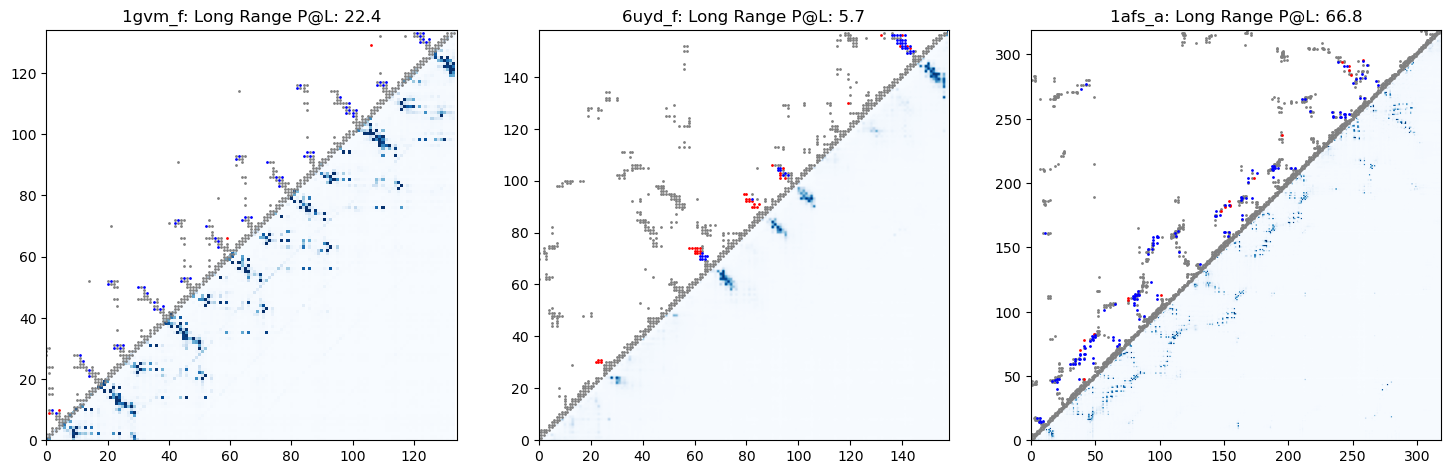

In [12]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

## MSA Transformer Predictions

In [13]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [14]:
# This is where the data is actually read in
PDB_IDS = ["1gvm_f", "1ae7_a", "1afs_a"]
structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-1]) 
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"../data/alignments/aligned_{name.lower()}.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

In [15]:
clear_model(msa_transformer)
try:
    msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
    msa_transformer = msa_transformer.eval().cuda()
    msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

    msa_transformer_predictions = {}
    msa_transformer_results = []
    for name, inputs in msas.items():
        inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
        msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
        msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
        msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
        pdb_indices = get_pdb_residues(name)
        if len(pdb_indices) > 0:
            msa_transformer_predictions[name] = msa_transformer_predictions[name][pdb_indices][:,pdb_indices]
        metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[name]))
        msa_transformer_results.append(metrics)
    msa_transformer_results = pd.DataFrame(msa_transformer_results)
    display(msa_transformer_results)
except BaseException as e:
    print(e)
clear_model(msa_transformer)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1gvm_f,MSA Transformer (Unsupervised),0.734012,0.485075,0.791045,0.923077,0.806593,0.589552,0.850746,1.000000,0.624796,0.455224,0.641791,0.769231,0.431823,0.268657,0.417910,0.576923
1,1ae7_a,MSA Transformer (Unsupervised),0.799570,0.714286,0.813559,0.826087,0.398873,0.235294,0.338983,0.565217,0.479538,0.378151,0.474576,0.521739,0.778250,0.605042,0.796610,0.913043
2,1afs_a,MSA Transformer (Unsupervised),0.817094,0.686520,0.842767,0.904762,0.466012,0.266458,0.452830,0.666667,0.437005,0.231975,0.383648,0.682540,0.767191,0.664577,0.786164,0.825397


NameError: name 'msa_transformer_predictions' is not defined

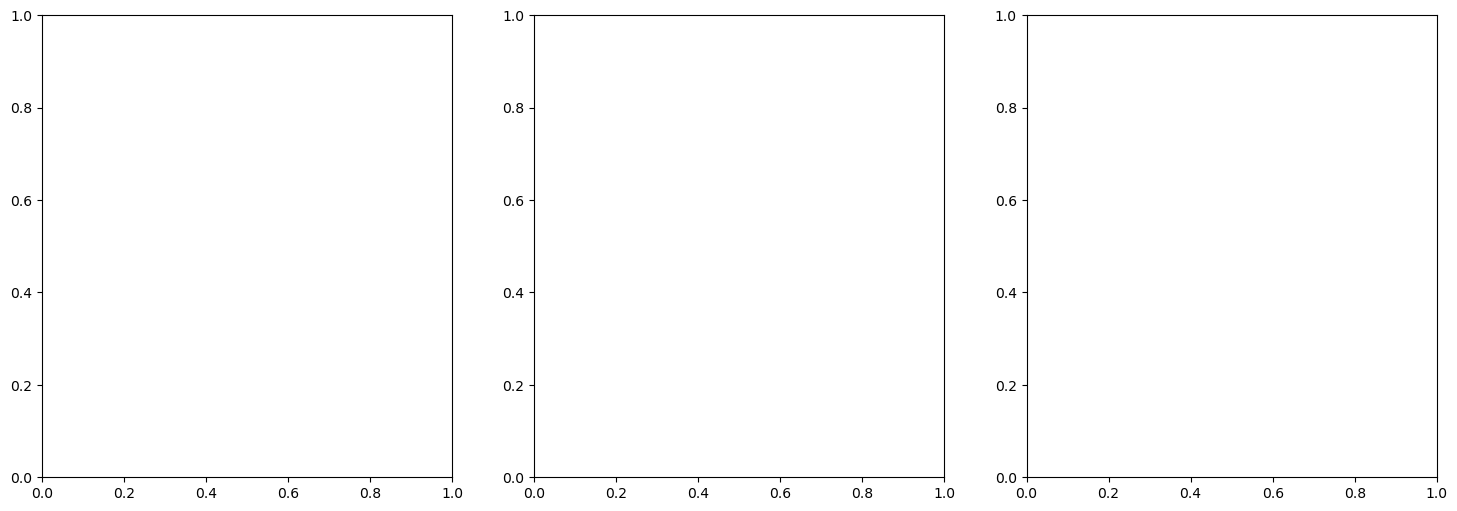

In [15]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = msa_transformer_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

In [15]:
# msa_transformer = None
# msa_transformer_embeddings = None
# msa_transformer_batch_tokens = None
# msa_transformer_alphabet = None
# msa_transformer_predictions = None

# gc.collect()
# torch.cuda.empty_cache()

In [19]:
from einops import rearrange

row_attention_tensors = []

for name, inputs in msas.items():

    inputs = greedy_select(inputs, num_seqs=128)
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])

    # Free up memory
    msa_transformer_batch_labels = None
    msa_transformer_batch_strs = None
    gc.collect()
    torch.cuda.empty_cache()

    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)

    with torch.no_grad():
        result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[12], need_head_weights=True, return_contacts=True)

    row_attentions = result['row_attentions'].cuda()
    #output_embeddings = result['representations'][12].cuda()
    #query_features = output_embeddings[:, 0, 1:, :]  # remove start token
    row_attentions = row_attentions[..., 1:, 1:]  # remove start token
    row_attentions = rearrange(row_attentions, 'b l h i j -> b (l h) i j')
    msa_attention_features = torch.cat((torch.mean(row_attentions, dim=2), torch.mean(row_attentions, dim=3)), dim=1)
    msa_attention_features = msa_attention_features.permute((0, 2, 1))
    #lstm_input = torch.cat([query_features, msa_attention_features], dim=2)
    row_attention_tensors.append(row_attentions.cpu().numpy())

# Testing

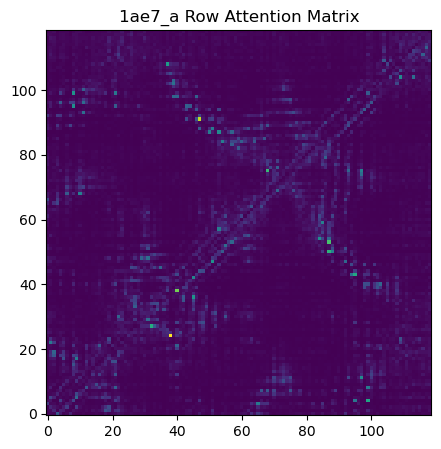

In [56]:
""" Function to plot the attention matrix as a heatmap. """
def plot_attention_matrix(attention_matrix, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(attention_matrix)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title(title)
    plt.show()

for i in range(len(row_attention_tensors)):
    if i !=1:
        continue
    row_matrix = row_attention_tensors[i][0,-3,:,:]

    plot_attention_matrix(row_matrix, PDB_IDS[i] + " Row Attention Matrix")

In [19]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [16]:
msa_transformer_embeddings = {}
for name, inputs in msas.items():
    if len(inputs) < 1000:
        continue
    print(inputs[0])
    inputs = greedy_select(inputs, num_seqs=256) ## Should be 512
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    with torch.no_grad():
        result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[12], need_head_weights=True, return_contacts=True)
    msa_transformer_embeddings[name] = result
torch.cuda.empty_cache()
print("Done!")

('1gvm_F mol:protein length:136  AUTOLYSIN', 'MKGGIVHSDGSYPKDKFEKINGTWYYFDSSGYMLADRWRKHTDGNWYWFDNSGEMATGWKKIADKWYYFNEEGAMKTGWVKYKDTWYYLDAKEGAMVSNAFIQSADGTGWYYLKPDGTLADRPEFTVEPDGLITVK')


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 23.65 GiB total capacity; 22.78 GiB already allocated; 42.81 MiB free; 23.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [86]:
torch.save(msa_transformer_embeddings['1afs_a'], '../data/embeddings/embeddings_1afs_a.pt')

In [84]:
tensor = torch.load('../data/embeddings/embeddings_1afs_a.pt')

In [22]:
tensor.shape

NameError: name 'tensor' is not defined

In [93]:
tensor = torch.load('../data/embeddings/embeddings_1gvm_f.pt')

In [94]:
tensor.shape

torch.Size([1, 512, 137, 768])

In [15]:
clear_model(msa_transformer)

In [9]:
# This is where the data is actually read in
PDB_IDS = ["1afs_a"]
structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-1]) 
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"../data/alignments/aligned_{name.lower()}.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

## Get indices for the residues found in the pdb structure
#pdb_residues = {
#    name: get_pdb_residues(name)
#    for name in PDB_IDS
#}

In [8]:
MAX_MSA_ROW_NUM = 256  # 256
MAX_MSA_COL_NUM = 1023  # start token +1 1024

In [9]:
def extract_msa_transformer_features(msa_seq, msa_transformer, msa_batch_converter, device=torch.device("cpu")):
    msa_seq_label, msa_seq_str, msa_seq_token = msa_batch_converter([msa_seq])
    msa_seq_token = msa_seq_token.to(device)
    msa_row, msa_col = msa_seq_token.shape[1], msa_seq_token.shape[2]
    print(f"{msa_seq_label[0][0]}, msa_row: {msa_row}, msa_col: {msa_col}")

    if msa_col > MAX_MSA_COL_NUM:
        print(f"msa col num should less than {MAX_MSA_COL_NUM}. This program force the msa col to under {MAX_MSA_COL_NUM}")
    msa_seq_token = msa_seq_token[:, :, :MAX_MSA_COL_NUM]

    ### keys: ['logits', 'representations', 'col_attentions', 'row_attentions', 'contacts']
    msa_transformer_outputs = msa_transformer(
        msa_seq_token, repr_layers=[12],
        need_head_weights=True, return_contacts=True)
    msa_row_attentions = msa_transformer_outputs['row_attentions']
    msa_representations = msa_transformer_outputs['representations'][12]
    msa_query_representation = msa_representations[:, 0, 1:, :]  # remove start token
    msa_row_attentions = msa_row_attentions[..., 1:, 1:]  # remove start token

    return msa_query_representation, msa_row_attentions

In [10]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [11]:
#name = "1afs_a"
name = "6uyd_f"

In [12]:
inputs = read_msa(f"../data/alignments/aligned_{name.lower()}.a3m")
input_msa = greedy_select(inputs, num_seqs=256)

In [13]:
representation, attention = extract_msa_transformer_features(input_msa, msa_transformer, msa_transformer_batch_converter, torch.device("cuda:0"))

6uyd_F mol:protein length:177  Envelope glycoprotein E2, msa_row: 256, msa_col: 178


In [17]:
need_row_attention=True

In [24]:
def forward(msa_query_embeddings, msa_row_attentions):
        msa_query_embeddings = linear_proj(msa_query_embeddings)

        if self.need_row_attention:
            msa_row_attentions = rearrange(msa_row_attentions, 'b l h i j -> b (l h) i j')
            msa_attention_features = torch.cat((torch.mean(msa_row_attentions, dim=2), torch.mean(msa_row_attentions, dim=3)), dim=1)
            msa_attention_features = msa_attention_features.permute((0, 2, 1))

            lstm_input = torch.cat([msa_query_embeddings, msa_attention_features], dim=2)

        else:
            lstm_input = msa_query_embeddings
        
        return lstm_input
        #lstm_input = lstm_input.permute((1, 0, 2))
        #lstm_output, lstm_hidden = self.lstm(lstm_input)
        #lstm_output = lstm_output.permute((1, 0, 2))
        #label_output = self.to_property(lstm_output)

        #return label_output

In [26]:
torch.cuda.set_device(0)
lstm_input = forward(representation, attention)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [22]:
linear_proj = nn.Sequential(
            nn.Linear(768, 768 // 2),
            nn.InstanceNorm1d(768 // 2),
            nn.ReLU(),
            nn.Linear(768 // 2, 768 // 4),
            nn.InstanceNorm1d(768 // 4),
            nn.ReLU(),
            nn.Linear(768 // 4, 768 // 4),
        )